In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [78]:
import json
import pandas as pd
import numpy as np
import time
import heapq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 
from yellowbrick.cluster import KElbowVisualizer

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
likes_path = "/content/drive/MyDrive/Tesi/easytour-likes-2022-03MAR-21.json"
schede_path = "/content/drive/MyDrive/Tesi/easytour-schede-2022-03MAR-21.json"
data_path = "/content/drive/MyDrive/Tesi/data.csv"

In [6]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path, encoding_errors='ignore')  

In [7]:
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_likes_ids = df_likes[["id", "userId"]]

In [8]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,['spiaggia'],"['paradiso', 'amant', 'sole', 'mare', 'sole', ...",0.0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,2.0,0,0,0,0,0,1,0.0,9
1,620abb33ff8ae67f37cafe3c,442,[],"['spiaggia', 'isola', 'spiaggia', 'mare', 'ter...",3600000.0,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,0,413.0,0,0,0,0,0,1,60.0,41
2,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'sconsi...",3600000.0,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,414.0,0,0,0,0,0,1,60.0,41
3,62349ff2272ae5672fbc3135,632,['big'],"['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
4,6234aa65272ae5672fbc34c2,632,"['wat', 'tempio']","['spiaggia', 'pena', 'tempio', 'big', 'tempio'...",0.0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,61f57f62306802033034ceed,536,"['avventura', 'cascata']","['esperienza', 'step', 'contatto', 'realtà', '...",259200000.0,2022-01-29T17:54:42.761Z,2022-01-29T17:54:42.000+00:00,0,42.0,0,0,0,0,0,1,4320.0,57
4352,61f668fa306802033034d239,536,['avventura'],"['spalla', 'esperienza', 'lascito', 'vista', '...",57600000.0,2022-01-30T10:31:22.977Z,2022-01-30T10:31:22.000+00:00,0,35.0,0,0,0,0,0,1,960.0,57
4353,620bbf26b1675d6cc11232f8,431,"['loma', 'polmon']","['mese', 'sole', 'capital', 'nuvola', 'nebbia'...",9000000.0,2022-02-15T14:56:39.554Z,2022-02-15T14:56:38.000+00:00,1,37.0,0,0,0,0,0,1,150.0,41
4354,61f3c6add91e9928f6e0922a,431,['lima'],"['angolo', 'turista', 'calor', 'gent', 'bellez...",172800000.0,2022-02-01T16:57:01.557Z,2022-01-28T10:34:21.000+00:00,1,51.0,0,0,0,0,0,1,2880.0,59


# Tf-Idf

In [82]:
def compute_tfidf_on_every_category(data):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=3,
                                          max_df=0.25)
  # description and title are put together
  text = data['description'] + data['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [9]:
def compute_tfidf_category(data, category:str):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=3,
                                          max_df=0.25)
  # description and title are put together
  data_category = data[data[category]!=0]
  text = data_category['description'] + data_category['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data_category.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [83]:
df_tfidf = compute_tfidf_on_every_category(data)
df_tfidf

,10,180,1h,39,3d,4h,4x4,abat,abazia,abbacchio,...,zoo,zoologia,zucca,zucchero,zucchin,zucchina,zuppa,zuppetta,zuppiera,élite
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
categories = ["aria aperta", "cultura", "food", "sport", "tempo libero", "viaggi"]
tfidf_dict = dict()
for c in categories:
  tfidf_dict[c] = compute_tfidf_category(data, category=c)

In [12]:
tfidf_dict["food"]

,10,180,abbacchio,abbinamento,abbondanza,abbuffata,abilità,abitant,abitazion,abito,...,zia,zio,zoccolett,zona,zucca,zucchero,zucchin,zucchina,zuppa,zuppetta
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.140543,0.0,0.102703,0.0,0.0,0.00000,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.105997,0.0,0.0,0.00000,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.218150,0.0,0.0,0.00000,0.0
4263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
4309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.23489,0.0


# Embeddings

## Word2Vec

## Transformers

# Recommender systems

In [80]:
df_likes_ids.userId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
3        True
5        True
6       False
        ...  
1338    False
1425     True
1458    False
1459    False
1468    False
Name: userId, Length: 116, dtype: bool

In [13]:
#list of user
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates() #some ids in likes are not in posts -> some users liked posts but not posted one
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
#list of posts and users that liked that post
posts_with_likes = df_likes_ids.groupby("id").userId.apply(list)
posts_with_likes

id
60e4443551c2214957f38e7e    [119, 336]
60e81a2e2a0546578b18abc0    [181, 304]
60e875c0d1bf8f316bb5a269    [149, 312]
60eda0a50f824d72efa23109         [312]
60f5ebf51376a816619182ab         [149]
                               ...    
6236fbc5272ae5672fbc4b10    [180, 640]
62370be5272ae5672fbc4b2e         [149]
623789ab272ae5672fbc4f3b         [180]
62378f92272ae5672fbc4fcc         [180]
623794ee272ae5672fbc5066    [180, 616]
Name: userId, Length: 1124, dtype: object

In [24]:
data_with_ids = data.drop(columns=["datePublishing", "creationDate", "duration", "description", "title", "counterUseful", "viewCounter"])

In [25]:
X = data.drop(columns=["id", "userId", "description", "title", "datePublishing", "creationDate", "duration", "counterUseful", "viewCounter"])

In [26]:
X

,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,0,0,0,0,0,1,0.0,9
1,0,0,0,0,0,1,60.0,41
2,0,0,0,0,0,1,60.0,41
3,0,0,0,0,0,1,0.0,10
4,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...
4351,0,0,0,0,0,1,4320.0,57
4352,0,0,0,0,0,1,960.0,57
4353,0,0,0,0,0,1,150.0,41
4354,0,0,0,0,0,1,2880.0,59


## **Method \#1**

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [84]:
cosine_sim = cosine_similarity(df_tfidf, df_tfidf)

In [85]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [86]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
92    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [87]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 61f6ce0b306802033034e3e7
Title: Le spiagge più belle della Sardegna
Description: La Sardegna è una regione ricca di spiagge meravigliose e mare dal colore cristallino, cercheremo di aiutarvi a trovare le spiagge più belle e quelle che secondo noi non potete assolutamente perdervi se fate un viaggio in questa regione fantastica!

📌Berchida
Berchida è una delle spiagge più lunghe e spaziosi della Sardegna. La Spiaggia è posizionata poco sopra il Golfo di Orosei ed è quasi tutta di sabbia finissima, inoltre, riesce a sorprenderti per i colori della sua acqua, davvero cristallina. La grandezza della spiaggia gioca a favore anche per la possibilità di avere un po’ di privacy e relax.

📌Spiaggia di S’archittu
Questa spiaggia è situata nella parte ovest della Sardegna poco sopra Oristano. La spiaggia in sé non è molto grande quindi vi consigliamo di arrivare presto per trovare posto. La particolarità è la presenza di un arco, appunto Archittu, formato dalla scogliera che rac

## **Method \#2**

**Method #2:** Similarity of users is given by the number of common clusters for the posts they made or liked 

### Clusters

In [ ]:
#Plot data using SVD
def plot_with_SVD(data, categories:list, tfidf_dict:dict):
  svd_dict = dict()
  for c in categories:
    tfidf = tfidf_dict[c]
    data_with_tfidf = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_with_tfidf.drop(columns=categories, inplace=True)
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    svd = svd.fit_transform(data_with_tfidf)
    svd_dict[c] = svd
    plt.scatter(svd[:,0], svd[:,1])
    plt.title("Category: " + c)
    plt.show()
  return svd_dict

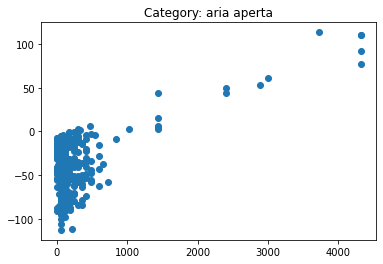

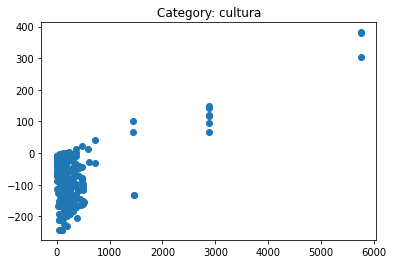

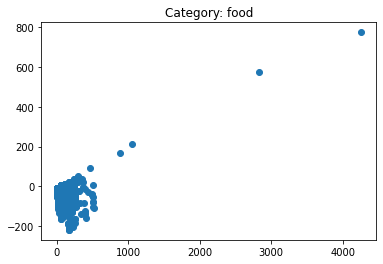

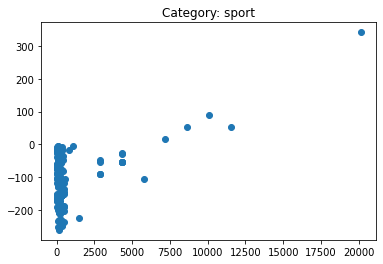

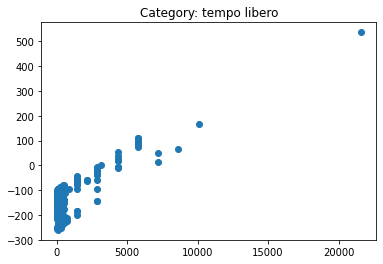

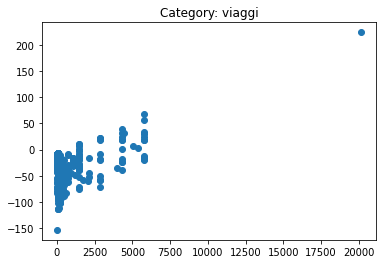

In [ ]:
#svd_dict = plot_with_SVD(X, categories, tfidf_dict)

In [ ]:
#Plot results
def plotKMeans(label, df, category):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters for {}'.format(len(u_labels), category))
  plt.legend()
  plt.show()

In [ ]:
def kmeans_tests(data, category, svd_dict, clusters_number=10, steps=1):
  inertia = []
  times = dict() #{k:time_needed}
  K = range(2,clusters_number,steps) 
  for k in K:
      #Fit 
      start = time.time()
      kmeanModel = KMeans(n_clusters=k)
      kmeans = kmeanModel.fit(data)
      time_needed = time.time() - start
      times[k] = time_needed
      #Elbow
      inertia.append(kmeanModel.inertia_)
      #Clusters
      label = kmeans.predict(data)
      plotKMeans(label, svd_dict[category], category)
  return inertia, times, K

In [ ]:
def elbow_and_statistics(inertia, times, K):
  #Elbow
  plt.figure(figsize=(10,3))
  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()
  print("\n")
  #Inertia
  for k,value in zip(K, inertia):
    print("Inertia for {} clusters is: {}".format(k,value))
  print("\n")
  #Times needed
  for k,v in times.items():
    print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

In [ ]:
def elbow_visualizer(data, k):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=k)
  visualizer.fit(X)        
  visualizer.show() 

In [ ]:
def kmeans_computation(data, tfidf_dict, categories:list, svd, k, visualizer=False):
  assert type(categories)==list, "Expected list as input not {}".format(type(categories))
  for c in categories:
    print("Category: {}".format(c))
    tfidf = tfidf_dict[c]
    data_category = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_cleaned = data_category.drop(columns=categories)
    if visualizer:
      #kmeans
      inertia, times, K = kmeans_tests(data_cleaned, c, svd, k)
      # Elbow and inertia
      elbow_and_statistics(inertia, times, K)
    else:
      elbow_visualizer(data_cleaned, k)  

Category: aria aperta


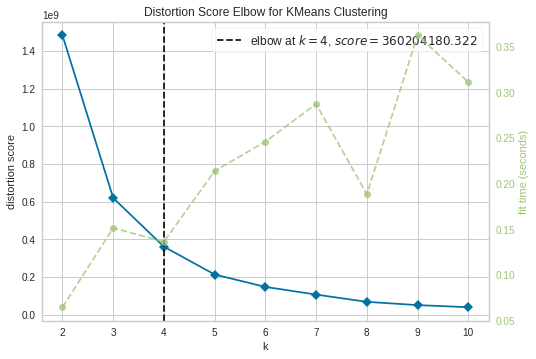

Category: cultura


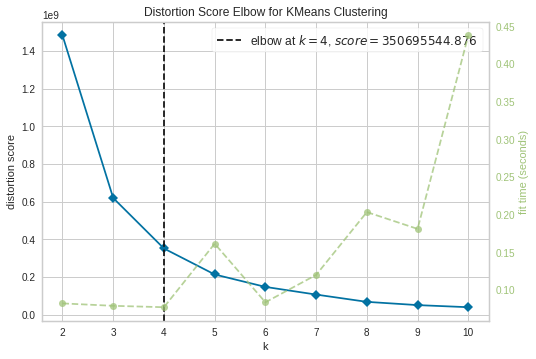

Category: food


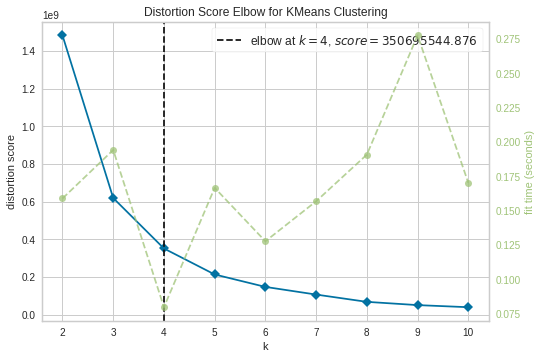

Category: sport


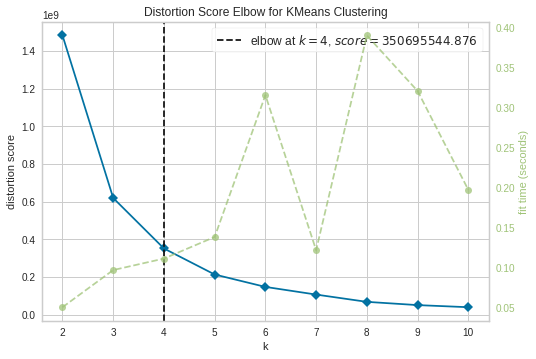

Category: tempo libero


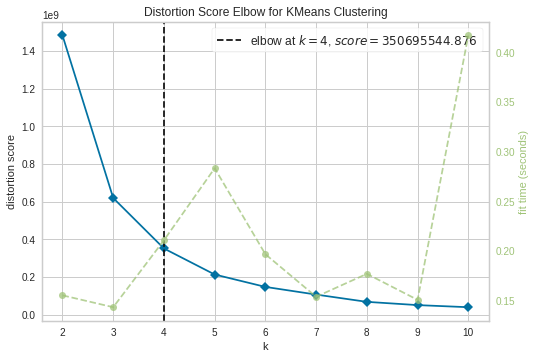

Category: viaggi


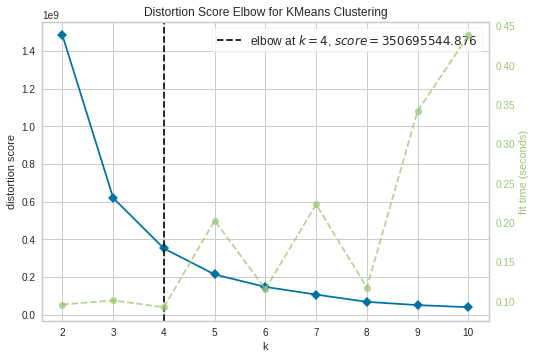

In [ ]:
#kmeans_computation(["food"])
#kmeans_computation(X, tfidf_dict, categories, svd_dict, 10)

### RS

In [27]:
optimal_number_clusters = {"aria aperta":4, "cultura":4, "food":4, "sport":4, "tempo libero":4, "viaggi":4}
#optimal_number_clusters = {"aria aperta":3, "cultura":3, "food":3, "sport":3, "tempo libero":3, "viaggi":3}

In [28]:
kmeans_dict = dict()
for k,v in optimal_number_clusters.items():
  kmeanModel = KMeans(n_clusters=v)
  print("Category '{}' has {} clusters".format(k,v))
  tfidf = tfidf_dict[k]
  data_category = pd.concat([X[X[k]!=0], tfidf], axis=1)
  data_cleaned = data_category.drop(columns=categories)
  kmeans = kmeanModel.fit(data_cleaned.values)
  kmeans_dict[k] = kmeans
  #print number of posts in each cluster
  labels = kmeans.labels_
  count_elem_per_cluster = pd.DataFrame(labels).value_counts()
  print(count_elem_per_cluster)
  print()

Category 'aria aperta' has 4 clusters
0    584
3     72
2      8
1      7
dtype: int64

Category 'cultura' has 4 clusters
0    657
3     91
2      6
1      3
dtype: int64

Category 'food' has 4 clusters
0    792
3    277
2     21
1      2
dtype: int64

Category 'sport' has 4 clusters
1    293
0     13
3      4
2      1
dtype: int64

Category 'tempo libero' has 4 clusters
0    489
3     28
1     14
2      1
dtype: int64

Category 'viaggi' has 4 clusters
0    693
3     59
1     25
2      1
dtype: int64




The distance between two user is computed in the following way: 

1.   for each category, the distance between two users is computed as the sum of the differences in numbers of posts in each cluster;
2.   the total distance is computed using the following formula: distance = $∑_{c=1}^r d[c]rank(c)$, where d is a list of distances per category computed in the previous step and rank(c) is a weight that consider the ranking of the category c for the target user (the ranking depends on the number of posts, i.e. the first post in the ranking is the category that has the highest number of posts)

In [56]:
from itertools import groupby

def get_similarity(t):
  return t[1]

# get the ranking of the categories for the target user 
# the first category is the one with more posts
# return: list of tuples (category, #posts)
def ranking_target(target_categories):
  scores_clusters = [(cat, len(s)) for cat, cluster in target_categories.items() for s in cluster.values()]
  scores_categories = []
  for i, g in groupby(sorted(scores_clusters), key=lambda x: x[0]):
      scores_categories.append([i, sum(v[1] for v in g)])
  scores_categories.sort(key=lambda x: x[1], reverse=True)
  return scores_categories

# retrieve the score for a certain category
def get_score_category(ranking, category):
  score = 0
  for r in ranking:
    if r[0] == category:
      score = r[1]
  return score

# retreive ranking of a category
def get_ranking_category(ranking, category):
  for i,r in enumerate(ranking):
    if r[0] == category:
      return i+1
  #category not in ranking -> target user has not posted in such category
  return (len(ranking)+1)

# compute the distance between two users, given a category
def get_cluster_distance(user_clusters:dict, target_clusters:dict):
  distance = 0
  if not target_clusters: #target has no clusters for this category
    distance = sum([len(cluster) for cluster in user_clusters.values()])
  elif not user_clusters:
    distance = sum([len(cluster) for cluster in target_clusters.values()])
  else:
    #take all the clusters names
    target_keys_set = set(target_clusters.keys())
    user_keys_set = set(user_clusters.keys())
    keys_set = target_keys_set | user_keys_set
    #compute distance for each cluster of the category and update total distance
    for k in keys_set:
      target_clusters_k = 0
      user_clusters_k = 0
      if k in target_keys_set:
        target_clusters_k = len(target_clusters[k])
      if k in user_keys_set:
        user_clusters_k = len(user_clusters[k])
      distance += abs(user_clusters_k-target_clusters_k)
  return distance

# Compute the distance between the target user and all the other users
# and return the most similar ones (the number can be specified using top) 
def distance(target_user, partitions_users, top=5):
  heap = []
  heapq.heapify(heap)
  ranking = ranking_target(partitions_users[target_user])
  for user,partitions in partitions_users.items():
    if user == target_user:
      continue 
    distance = 0
    for c in categories:
      target_category_score = get_score_category(ranking, c)
      target_category_ranking = get_ranking_category(ranking, c)
      user_category_clusters = {}
      if c in partitions:
        user_category_clusters = partitions[c]
      # check if target user has clusters for this category
      target_category_clusters = {} 
      if c in partitions_users[target_user]:
        target_category_clusters = partitions_users[target_user][c]
      #compute distance for the actual category and update total distance
      distance_category = get_cluster_distance(user_category_clusters,
                                               target_category_clusters)
      distance += distance_category * (len(categories)-target_category_ranking)
      #push in the heap
    heapq.heappush(heap, (user, distance))
  return heapq.nsmallest(top, heap, key=get_similarity) 

In [32]:
def print_posts_user(user):
  print("Posts for user {}:".format(user))
  posts = df_schede[df_schede["userId"]==user]
  for _, p in posts.iterrows():
    print(p.description)
    print("-"*100)

def print_info_for_user(user, partition, posts=False):
  print("Info about the clusters for the posts of user {}".format(user))
  partitions_categories = partition[user]
  for category,partitions in partitions_categories.items():
    print("Clusters for category {}: {}".format(category, len(partitions)))
    for cluster,array in partitions.items():
      print("#items in cluster {} for category {}: {}".format(cluster, category, len(array)))
    print()    

#### Considering posts users wrote

In [77]:
target_id = 129

In [58]:
# Compute the distribution of the posts in the clusters for each user
# partitions = {user1: {c0:[post12, post45], c1:[post1], c2:[post5]}, user2:{c0:[], c1:[]}, etc}
def posts_in_partition(data, categories, kmeans_dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    tfidf = tfidf_dict[c]
    data_category = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_post = data_category.drop(columns=categories)
    users = data_post["userId"]
    posts_ids = data_post["id"]
    data_post = data_post.drop(columns=["userId", "id"])
    # add posts to the partitions
    for u,p,d in zip(users, posts_ids, data_post.iterrows()):
      user = u
      post = p
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      if user in partitions:
          #check if category c already exists for userId
          if c in partitions[user]:
            #check if cluster already exists for the category c of userId
            if cluster in partitions[user][c]:
              partitions[user][c][cluster].append(post)
            else:
              partitions[user][c][cluster] = [post]
          else:
            partitions[user][c] = dict()
            partitions[user][c][cluster] = [post]
      else:
        partitions[user] = dict()
        partitions[user][c] = dict()
        partitions[user][c][cluster] = [post]
  return partitions

In [59]:
partitions_by_user = posts_in_partition(data_with_ids,
                                        categories,
                                        kmeans_dict)

In [60]:
print_info_for_user(target_id, partitions_by_user)

Info about the clusters for the posts of user 129
Clusters for category cultura: 2
#items in cluster 3 for category cultura: 2
#items in cluster 0 for category cultura: 8

Clusters for category food: 3
#items in cluster 2 for category food: 2
#items in cluster 3 for category food: 13
#items in cluster 0 for category food: 6

Clusters for category sport: 1
#items in cluster 1 for category sport: 6

Clusters for category tempo libero: 3
#items in cluster 0 for category tempo libero: 11
#items in cluster 3 for category tempo libero: 1
#items in cluster 1 for category tempo libero: 1

Clusters for category viaggi: 1
#items in cluster 0 for category viaggi: 2



In [61]:
print_posts_user(target_id)

Posts for user 129:
A differenza di molti miei amici non ho avuto la grande fortuna di viaggiare in vita mia.
Bali è stata la mia prima meta veramente importante. Inutile dire che mi sono innamorata al primo sguardo. 
Avevo deciso di non organizzare nel dettaglio la mia meta, non comprare guide, non documentarmi troppo attraverso foto o video del luogo. Volevo l'effetto Wow e quello ho avuto. Verde ovunque, persone felici, paesaggi mozzafiato. 
In un mese sono riuscita a girarla molto tutta in motorino, tra giungla e templi, risaie e scimmiette che attraversano la strada. Bali è magica. Ti senti avvolto da un abbraccio che ti paralizza. Non vorresti mai andartene.
----------------------------------------------------------------------------------------------------
Questa estate in moltissimi amici abbiamo scelto come destinazione la FìGrecia. Ma a differenza della maggior parte di loro che hanno deciso di trascorre le vacanze sulle isole frequentate da VIP con locali esclusivi la mia sc

In [62]:
best_users_from_posts = distance(target_id, partitions_by_user)
best_users_from_posts

[(427, 87), (218, 90), (200, 101), (294, 103), (180, 108)]

In [63]:
for u in best_users_from_posts:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 427
Clusters for category aria aperta: 2
#items in cluster 0 for category aria aperta: 11
#items in cluster 3 for category aria aperta: 3

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 7

Clusters for category food: 2
#items in cluster 3 for category food: 9
#items in cluster 0 for category food: 3

Clusters for category sport: 1
#items in cluster 1 for category sport: 2

Clusters for category tempo libero: 1
#items in cluster 0 for category tempo libero: 10

Clusters for category viaggi: 2
#items in cluster 0 for category viaggi: 14
#items in cluster 3 for category viaggi: 1

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 218
Clusters for category aria aperta: 2
#items in cluster 3 for category aria aperta: 1
#items in cluster 0 for category aria aperta: 5

Clusters for category cultura: 2
#items in cluster 0 for

#### Considering the posts the users liked

In [75]:
target_id = 129

In [64]:
# Compute distribution of the likes in the clusters for each user
# partitions = {user1: {c0:[like1, like4], c1:[like6], c2:[like3]}, user2:{c0:[], c1:[]}, etc}
def likes_in_partition(data, categories, kmeans_dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    tfidf = tfidf_dict[c]
    data_category = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_post = data_category.drop(columns=categories)
    posts_ids = data_post["id"]
    data_post = data_post.drop(columns=["userId", "id"])
    for p,d in zip(posts_ids, data_post.iterrows()):
      post = p
      try:
        users_list = posts_with_likes.at[p] #error if p is not in posts_with_likes
      except:
        # no one liked the post -> skip it
        continue
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      for user in users_list:
        if user in partitions:
            #check if category c already exists for userId
            if c in partitions[user]:
              #check if cluster already exists for the category c of userId
              if cluster in partitions[user][c]:
                partitions[user][c][cluster].append(post)
              else:
                partitions[user][c][cluster] = [post]
            else:
              partitions[user][c] = dict()
              partitions[user][c][cluster] = [post]
        else:
          partitions[user] = dict()
          partitions[user][c] = dict()
          partitions[user][c][cluster] = [post]
  return partitions

In [66]:
partitions_by_user_likes = likes_in_partition(data_with_ids,
                                        categories,
                                        kmeans_dict)

In [67]:
print_info_for_user(target_id, partitions_by_user_likes)

Info about the clusters for the posts of user 129
Clusters for category aria aperta: 2
#items in cluster 0 for category aria aperta: 4
#items in cluster 3 for category aria aperta: 1

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 5

Clusters for category food: 2
#items in cluster 0 for category food: 2
#items in cluster 3 for category food: 3

Clusters for category sport: 1
#items in cluster 1 for category sport: 1

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 4
#items in cluster 3 for category tempo libero: 1

Clusters for category viaggi: 2
#items in cluster 0 for category viaggi: 4
#items in cluster 1 for category viaggi: 1



In [76]:
print_posts_user(target_id)

Posts for user 129:
A differenza di molti miei amici non ho avuto la grande fortuna di viaggiare in vita mia.
Bali è stata la mia prima meta veramente importante. Inutile dire che mi sono innamorata al primo sguardo. 
Avevo deciso di non organizzare nel dettaglio la mia meta, non comprare guide, non documentarmi troppo attraverso foto o video del luogo. Volevo l'effetto Wow e quello ho avuto. Verde ovunque, persone felici, paesaggi mozzafiato. 
In un mese sono riuscita a girarla molto tutta in motorino, tra giungla e templi, risaie e scimmiette che attraversano la strada. Bali è magica. Ti senti avvolto da un abbraccio che ti paralizza. Non vorresti mai andartene.
----------------------------------------------------------------------------------------------------
Questa estate in moltissimi amici abbiamo scelto come destinazione la FìGrecia. Ma a differenza della maggior parte di loro che hanno deciso di trascorre le vacanze sulle isole frequentate da VIP con locali esclusivi la mia sc

In [68]:
best_users_from_likes = distance(target_id, partitions_by_user_likes)
best_users_from_likes

[(562, 36), (479, 44), (181, 45), (269, 45), (399, 45)]

In [72]:
for u in best_users_from_likes:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 562
Clusters for category aria aperta: 2
#items in cluster 0 for category aria aperta: 8
#items in cluster 3 for category aria aperta: 8

Clusters for category cultura: 2
#items in cluster 3 for category cultura: 2
#items in cluster 0 for category cultura: 13

Clusters for category food: 2
#items in cluster 0 for category food: 9
#items in cluster 3 for category food: 2

Clusters for category sport: 1
#items in cluster 1 for category sport: 3

Clusters for category viaggi: 2
#items in cluster 1 for category viaggi: 3
#items in cluster 0 for category viaggi: 2

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 479
Clusters for category aria aperta: 4
#items in cluster 2 for category aria aperta: 1
#items in cluster 0 for category aria aperta: 10
#items in cluster 3 for category aria aperta: 1
#items in cluster 1 for category aria aperta: 2

Clust

#### Show recommendations

In [69]:
def print_single_result(data, recommended_user):
  assert type(recommended_user) == tuple, "Use print_results for multiple users"
  posts = data[data["userId"]==recommended_user[0]]
  print("User: {}".format(recommended_user[0]))
  for _, p in posts.iterrows():
    print("Post:")
    print(p.description)
  print("-"*100)

def print_results(data, recommended_users):
  assert type(recommended_users)==list, "Use print_single_result for single user"
  for u in recommended_users:
    posts = data[data["userId"]==u[0]]
    print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      print("Post:")
      print(p.description)
    print("-"*100)

In [88]:
#print_single_result(df_schede, best_users[0])

In [89]:
#print_results(df_schede, best_users)

Choose the posts from the best users:


*   Consider posts with more likes
*   Consider from which cluster they come
*   Consider posts that most similar users like
